# Transferência de aprendizagem para classificação de imagens

## Transferência de aprendizagem

A transferência de aprendizado em machine learning é aproveitar os recursos de um modelo e ensinar coisas novas a ele.

Nesse projeto foi aproveitado o modelo MobileNetV2 e utilizou as bibliotecas keras e tensorflow para redes neurais

O método geralmente é feito para tarefas em que seu conjunto de dados tem poucos dados para treinar um modelo do zero.

Será passado fotos de gatos e cachorros para treinamento com pequeno número de amostras

### Importação das bibliotecas

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from IPython.display import display
from PIL import Image

### Carregamento das imagens

Para este estudo, serão utilizados 2 mil imagens de forma aleatória e balanceada entre gatos (mil) e cães (mil) para o treinamento do modelo.

Para o Teste (validação) foram separadas 600 imagens dividas entre gatos (300) e cães (300).

As imagens foram selecionadas à partir [Kaggle Cats and Dogs](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).

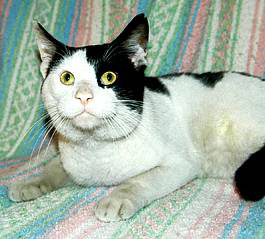

In [2]:
# visualizando um imagem da pasta de treinamento cat.
tf.keras.preprocessing.image.load_img(r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\kagglecatsanddogs_5340\PetImages\training_set\cat\cat.480.jpg")

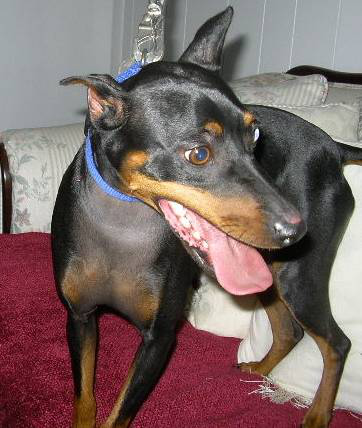

In [3]:
# visualizando uma imagem da pasta de treinamento dog.
tf.keras.preprocessing.image.load_img(r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\kagglecatsanddogs_5340\PetImages\training_set\dog\dog.13.jpg")

### Base de dados de treinamento e teste

#### Aumento de dados aleatórios
Irá introduzir rotação, zoom nas imagens, com isso aumenta a amostra e também diversifica o tipo de imagem de uma maneira artificial, será realizado para produzir alguns tipos de imagens que não pode ter na base de dados. Deseja introduzir diversidade de imagens na base de dados

Será utilizado o métdo ImageDataGenerator

In [4]:
# realizando o redimensionamento e a normalização no conjunto de treinamento.
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
path_training=r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\kagglecatsanddogs_5340\PetImages\training_set"
dataset_treinamento = gerador_treinamento.flow_from_directory(path_training,
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 2000 images belonging to 2 classes.


In [5]:
# realizando o redimensionamento e a normalização no conjunto de teste. 
gerador_teste = ImageDataGenerator(rescale=1./255)
path_test=r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\kagglecatsanddogs_5340\PetImages\test_set"
dataset_teste = gerador_teste.flow_from_directory(path_test,
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 600 images belonging to 2 classes.


### Rede neural pré-treinada

Será utilizado o modelo MobileNetV2 que já foi treinado para outros fins

Será utilizado todos os pesos das camadas do modelo que já foi treinado(know-how) e implementar apenas as camadas finais para o objetivo proposto que é classificar se o animal é uma gato ou cão

Isso reduzirá o tempo de treinamento já que criar uma rede neural do zero demanda tempo além de custo computacional (placa de video ou muita memória ram e bom processador)

In [6]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

In [7]:
# informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [8]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [9]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
    layer.trainable = False

### Camada densa ajustada

In [10]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

A última camada possui 1280 conexões para realizar a ligação com a nova camada foi utilizado a metade dessas conexões

Dropout irá descartar 20% das conexões para próxima camada, espera que não haja overfitting com essa redução ou o diminua

Foi criada uma camada densa de 2 conexões para classificação (gato,cão)

In [11]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

### Construção e treinamento da rede neural

In [12]:
# ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [13]:
# mostra as informações das camadas.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [14]:
# Adiciona as 6 camadas finais ao modelo.
len(network.layers)

160

In [15]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [16]:
# Realizando o treimanto com 10 epocas.
historico = network.fit(dataset_treinamento, epochs=10)

Epoch 1/10
16/16 [==============================] - 18s 889ms/step - loss: 0.2869 - accuracy: 0.8885
Epoch 2/10
16/16 [==============================] - 14s 867ms/step - loss: 0.1333 - accuracy: 0.9535
Epoch 3/10
16/16 [==============================] - 14s 886ms/step - loss: 0.1069 - accuracy: 0.9595
Epoch 4/10
16/16 [==============================] - 15s 910ms/step - loss: 0.0747 - accuracy: 0.9775
Epoch 5/10
16/16 [==============================] - 15s 945ms/step - loss: 0.0704 - accuracy: 0.9695
Epoch 6/10
16/16 [==============================] - 14s 886ms/step - loss: 0.0597 - accuracy: 0.9790
Epoch 7/10
16/16 [==============================] - 14s 880ms/step - loss: 0.0489 - accuracy: 0.9805
Epoch 8/10
16/16 [==============================] - 14s 897ms/step - loss: 0.0447 - accuracy: 0.9840
Epoch 9/10
16/16 [==============================] - 14s 862ms/step - loss: 0.0380 - accuracy: 0.9845
Epoch 10/10
16/16 [==============================] - 14s 864ms/step - loss: 0.0389 - accura

### Avaliação da rede neural

In [17]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

600/600 [==============================] - 10s 14ms/step - loss: 0.0940 - accuracy: 0.9650


[0.09400693327188492, 0.9649999737739563]

In [18]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

600/600 [==============================] - 9s 14ms/step


array([[9.9987555e-01, 1.2443140e-04],
       [9.9999905e-01, 1.0095225e-06],
       [9.9524850e-01, 4.7515365e-03],
       ...,
       [3.8153496e-01, 6.1846507e-01],
       [1.5972562e-02, 9.8402750e-01],
       [8.7682582e-07, 9.9999917e-01]], dtype=float32)

In [19]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
# classificação real do conjunto de teste.
dataset_teste.classes[:10] # 10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# função sklearn apenas para avaliar a acurácia do modelo
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.965

In [22]:
network.evaluate(dataset_teste)

600/600 [==============================] - 8s 14ms/step - loss: 0.0940 - accuracy: 0.9650


[0.09400693327188492, 0.9649999737739563]

Conforme o resultado, o modelo teve 96.50% de acurácia no conjunto de teste.

Plotar matriz de confusão

In [23]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

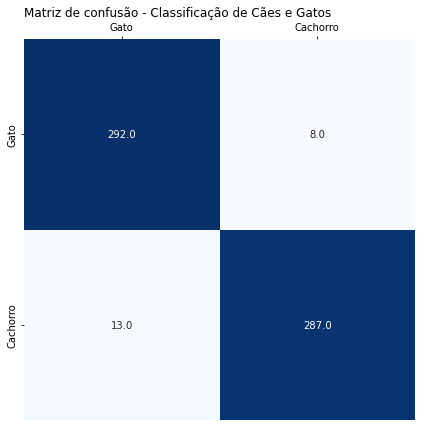

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Gato', 'Cachorro']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Gato', 'Cachorro']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'
plt.title(title, loc='left')
plt.show()

O modelo acertou 292 gatos e errou 8

O modelo acertou 287 Cães e errou 13

**Porcentagem de erro bem parecido para as duas classes**

**Cachorro = (8/300)*100= 2,67%**

**Gato = (13/300)*100= 4,33%**


In [25]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       300
           1       0.97      0.96      0.96       300

    accuracy                           0.96       600
   macro avg       0.97      0.97      0.96       600
weighted avg       0.97      0.96      0.96       600



O modelo teve um resultado satisfatório para detectar ambas imagens


# Salvar e carregar a rede neural

In [26]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
    json_file.write(model_json)

In [27]:
# Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\weights.hdf5")

In [28]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
    json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "Conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "bn_Conv1", "trainable": false, "dtype": "float32", "axis

In [29]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights(r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\weights.hdf5")
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [30]:
# conferindo as informações das camadas.
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

# Classificação de uma única imagem

Simular uma aplicação: Identificar imagens dentro de uma pasta se tem cachorro ou gato.

Irá testar com uma imagem de um cachorro, a imagem foi feita do cachorro da família.

Irá testar com uma imagem de um gato que foi retirada do google.

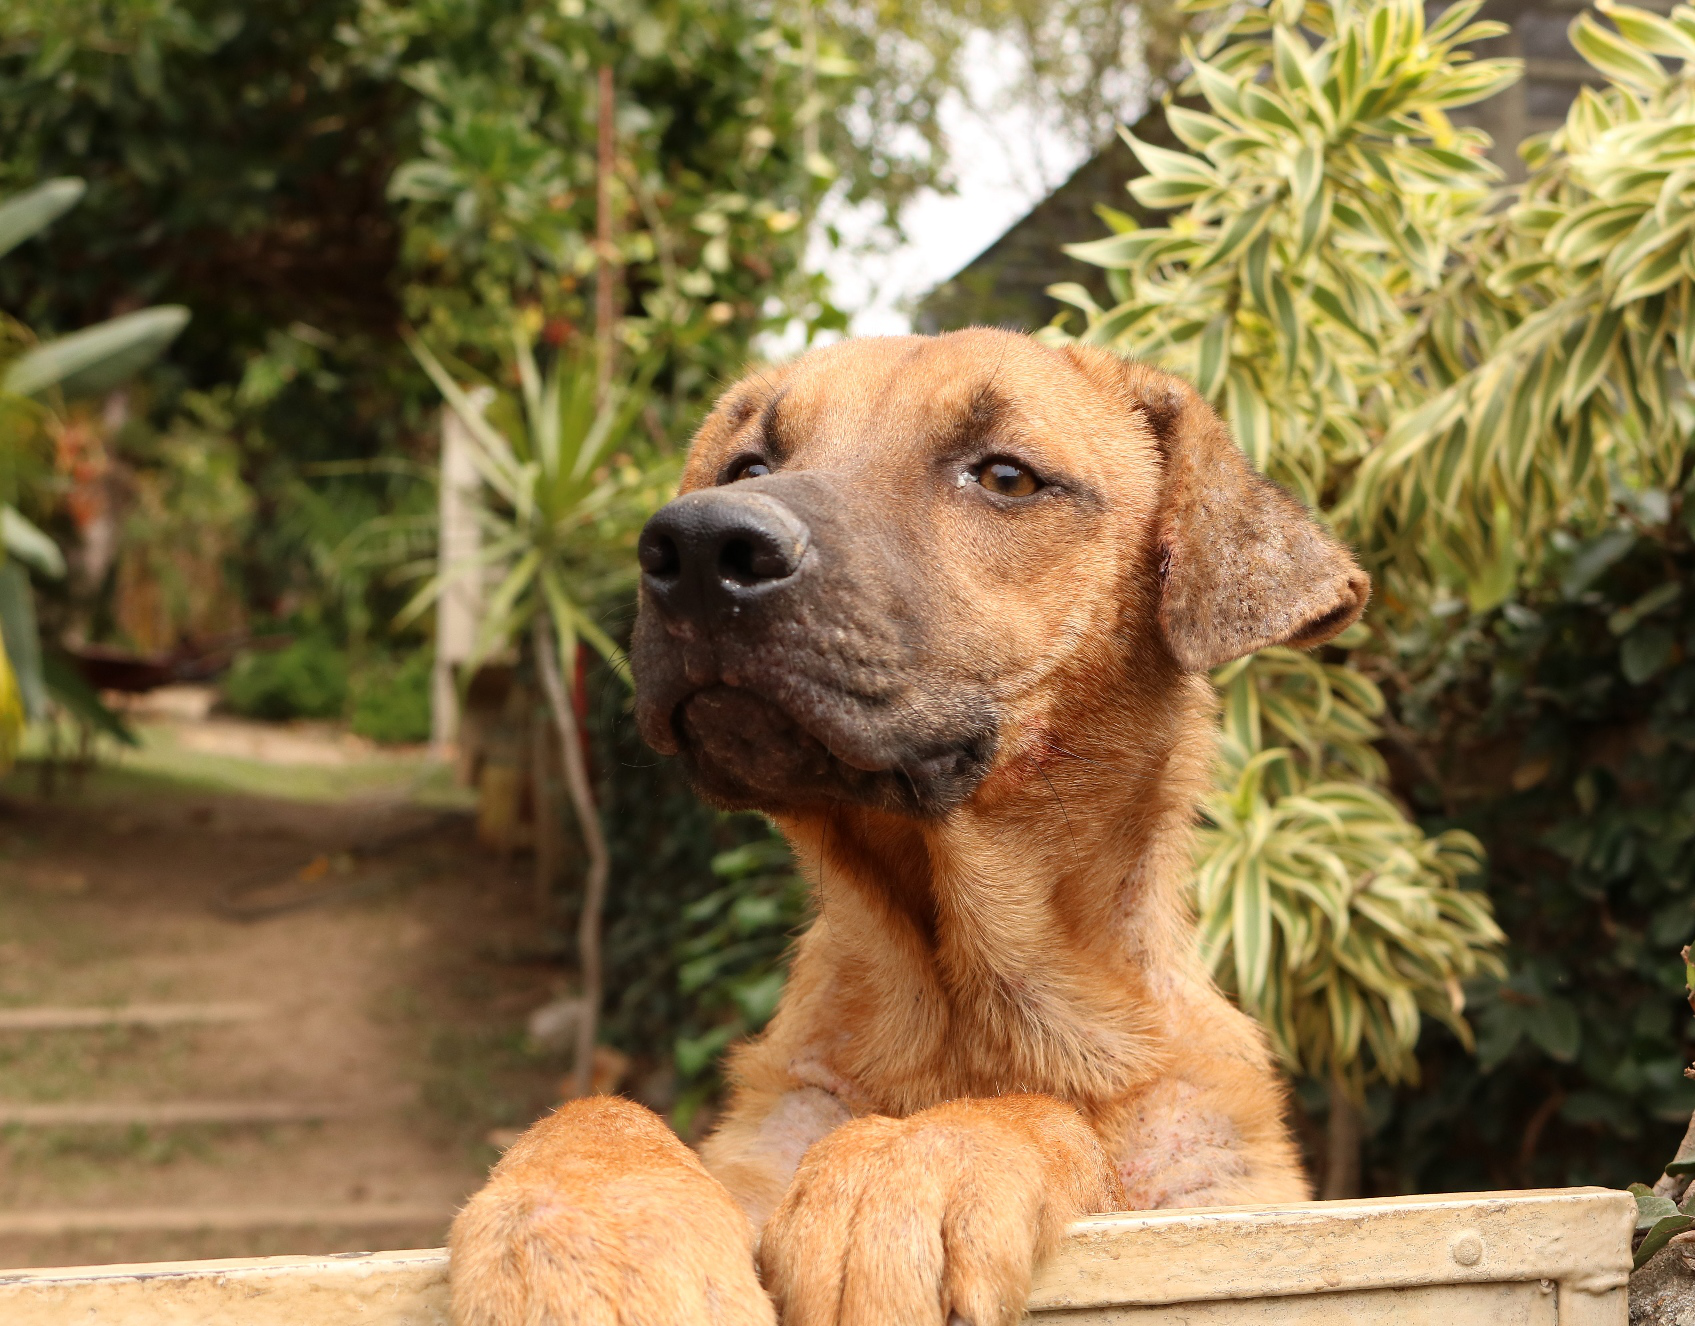

In [31]:
# carregando uma imagem
path_cachorro=r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\dog.1.jpg"
display(Image.open(path_cachorro))
imagem_cachorro = np.array(Image.open(path_cachorro))
real=1

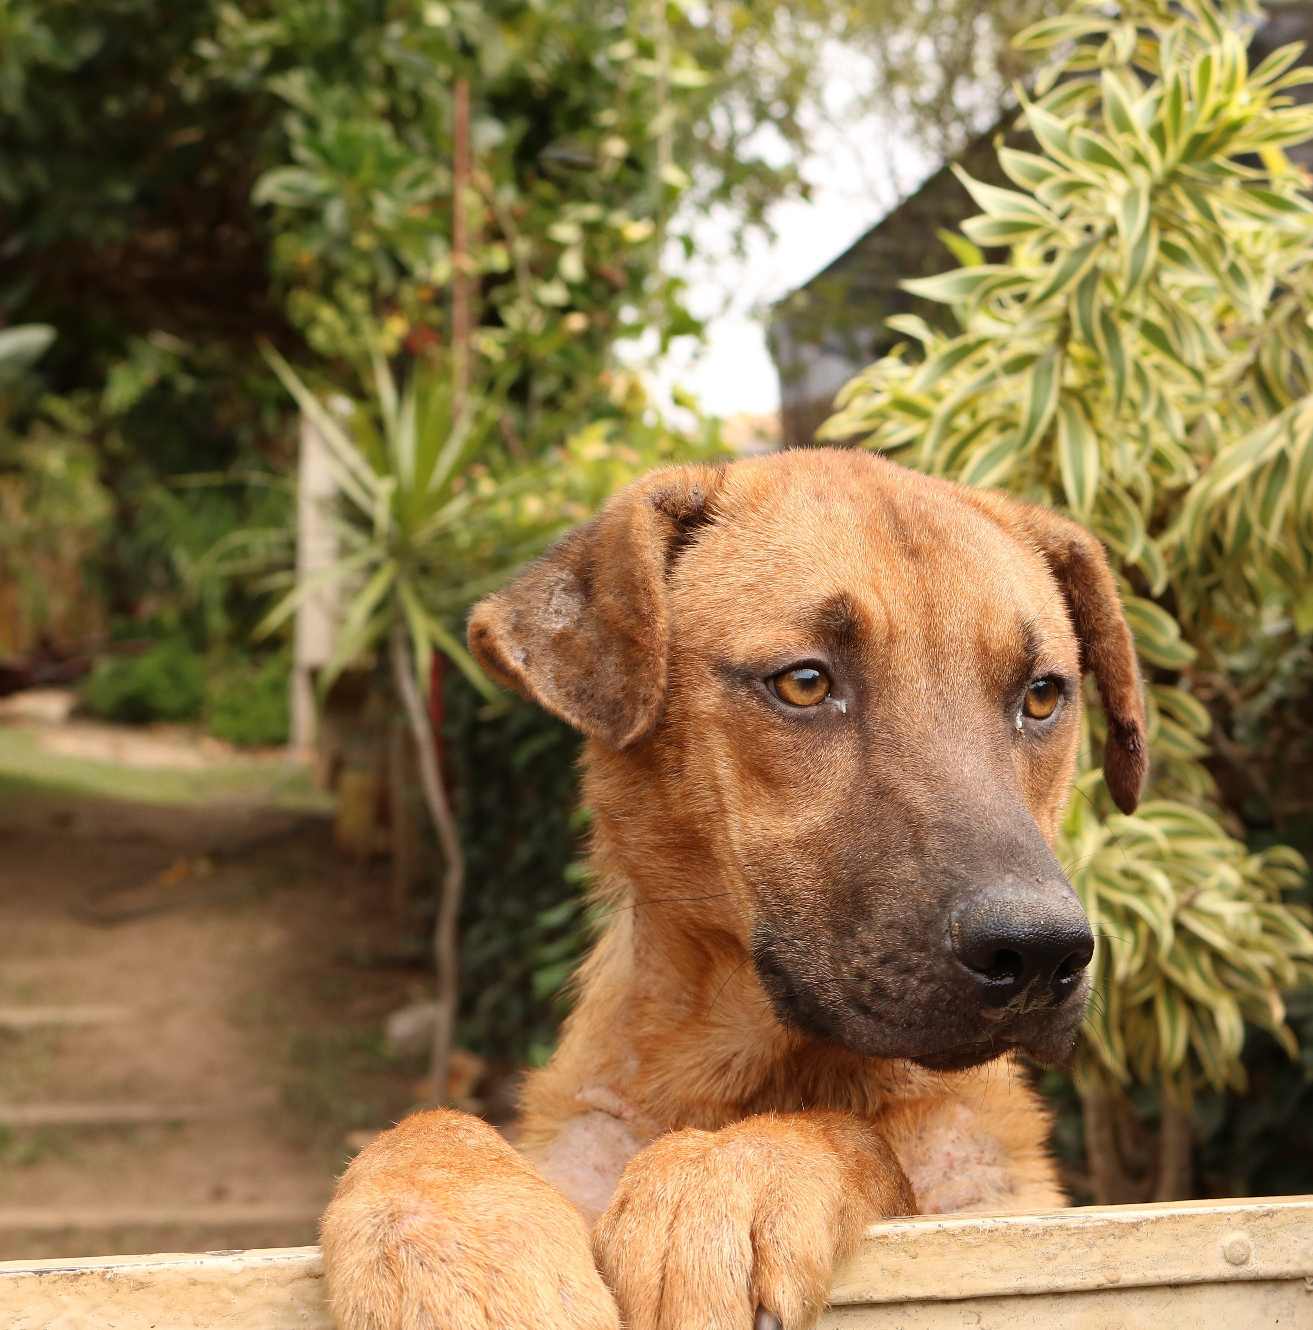

In [32]:
# carregando uma imagem
path_cachorro=r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\dog.3.jpg"
display(Image.open(path_cachorro))
imagem_cachorro2 = np.array(Image.open(path_cachorro))
real=1

In [33]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_cachorro  = cv2.resize(imagem_cachorro , (128, 128))
imagem_cachorro  = cv2.rotate(imagem_cachorro , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [34]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_cachorro2  = cv2.resize(imagem_cachorro2 , (128, 128))
imagem_cachorro2  = cv2.rotate(imagem_cachorro2 , cv2.ROTATE_90_COUNTERCLOCKWISE)

In [35]:
# Normalizando a imagem.
imagem_cachorro  = imagem_cachorro/255

In [36]:
# Normalizando a imagem.
imagem_cachorro2  = imagem_cachorro2/255

In [37]:
# Conferindo o formato
imagem_cachorro.shape

(128, 128, 3)

In [38]:
# Conferindo o formato
imagem_cachorro2.shape

(128, 128, 3)

In [39]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_cachorro  = imagem_cachorro.reshape(1,128,128,3)

In [40]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_cachorro2  = imagem_cachorro2.reshape(1,128,128,3)

In [41]:
# Realizando a previsão.
previsao = network_loaded(imagem_cachorro)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.1232531, 0.8767469]], dtype=float32)>

In [42]:
previsao_class = np.argmax(previsao)
previsao_class

1

In [43]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [44]:
if previsao_class == 0:
    print('O modelo identificou que o animal é um gato')
else:
    print('O modelo identificou que o animal é um cão')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que o animal é um cão
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 87.67%


In [45]:
# Realizando a previsão.
previsao = network_loaded(imagem_cachorro2)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00268503, 0.997315  ]], dtype=float32)>

In [46]:
previsao_class = np.argmax(previsao)
previsao_class

1

In [47]:
if previsao_class == 0:
    print('O modelo identificou que o animal é um gato')
else:
    print('O modelo identificou que o animal é um cão')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que o animal é um cão
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 99.73%


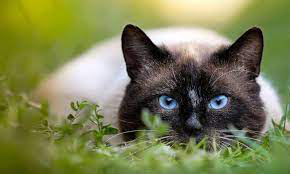

In [48]:
# Teste com gato
# carregando uma imagem
path_gato=r"D:\Cursos\Dio Dev Tech Unimed - Ciência de Dados\Tansfer Learning Python\cat.2.jfif"
display(Image.open(path_gato))
imagem_gato = np.array(Image.open(path_gato))
real=0

In [49]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem_gato = cv2.resize(imagem_gato, (128, 128))
imagem_gato = cv2.rotate(imagem_gato, cv2.ROTATE_90_COUNTERCLOCKWISE)

In [50]:
# Normalizando a imagem.
imagem_gato = imagem_gato / 255

In [51]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem_gato = imagem_gato.reshape(1,128,128,3)

In [52]:
# Realizando a previsão.
previsao = network_loaded(imagem_gato)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.96121085, 0.03878914]], dtype=float32)>

In [53]:
previsao_class = np.argmax(previsao)
previsao_class

0

In [54]:
if previsao_class == 0:
    print('O modelo identificou que o animal é um gato')
else:
    print('O modelo identificou que o animal é um cão')

if previsao_class==real:
    print('O modelo acertou!')
    print(f'O modelo conseguiu prever corretamente a imagem com uma precisão de {previsao[0][previsao_class]*100:.2f}%')
else:
    print('O modelo errou.')

O modelo identificou que o animal é um gato
O modelo acertou!
O modelo conseguiu prever corretamente a imagem com uma precisão de 96.12%
